In [ ]:
# get dataset
import tensorflow_datasets as tfds
# get libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import cv2
from sklearn.cluster import KMeans


In [ ]:
ds, ds_info = tfds.load('malaria', shuffle_files=True, with_info=True)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteNSBK9E/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
#look at the number of classes and their names

print("Num classes: " + str(ds_info.features['label'].num_classes))
print("Class names: " + str(ds_info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


We don't have 'features'but only image and label data available to us, which is representative of an IRL situation where we only have image data. (so no X vector, only Y with labels of images)

In [ ]:
train_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]',  'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

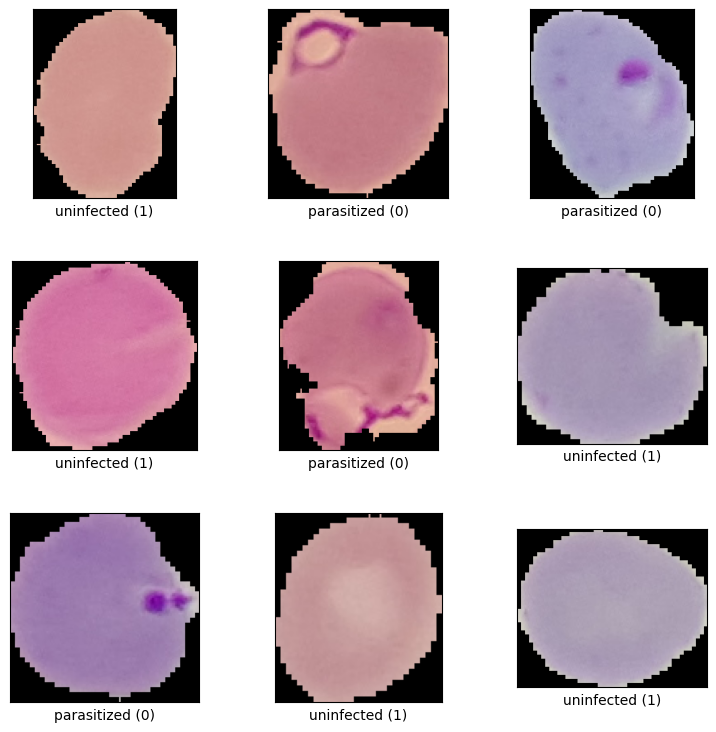

In [ ]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

vis = tfds.visualization.show_examples(ds, info)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.43666666666666665
Recall: 0.43666666666666665


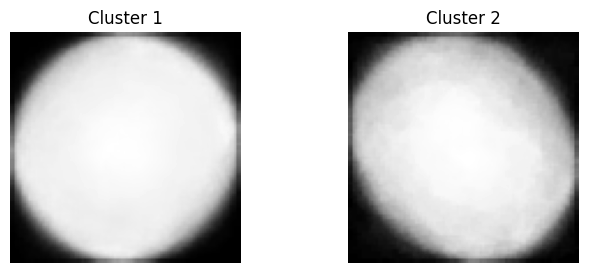

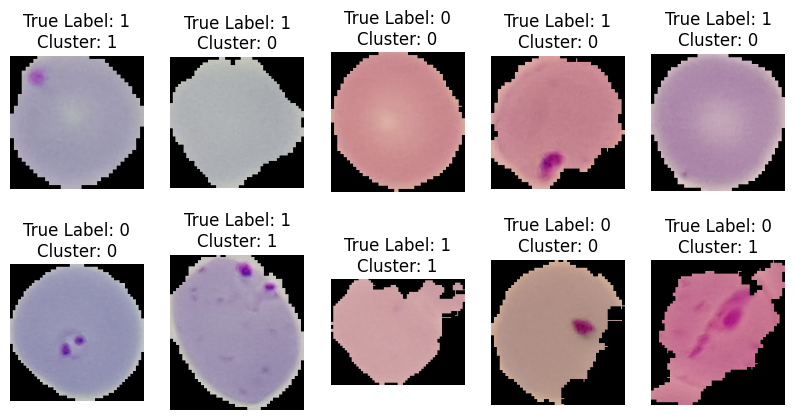

In [ ]:
#K-means clustering

from sklearn.metrics import recall_score


# Preprocess the images and collect the true labels
images = []
true_labels = []
for image, label in train_ds.take(10):  # Take a sample of images from the dataset
    # Resize the image to a consistent size
    img = tf.image.resize(image, [100, 100])
    # Convert image to grayscale
    img = tf.image.rgb_to_grayscale(img)
    # Convert the image tensor to a numpy array and flatten
    img = np.array(img).flatten()
    images.append(img)
    # Collect the true label
    true_labels.append(label.numpy())

# Convert the list of images to numpy array
images = np.array(images)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(images)

# Calculate accuracy
correct_predictions = 0
for true_label, cluster_label in zip(true_labels, kmeans.labels_):
    if true_label == cluster_label:
        correct_predictions += 1
accuracy = correct_predictions / len(true_labels)
print("Accuracy:", accuracy)

#Calculate recall
recall = recall_score(true_labels, kmeans.labels_, average='weighted')
print("Recall:", recall)

# Visualize cluster centers
cluster_centers = kmeans.cluster_centers_.reshape(-1, 100, 100)  # Reshape cluster centers to original image shape
plt.figure(figsize=(8, 3))
for i, center in enumerate(cluster_centers):
    plt.subplot(1, 2, i+1)
    plt.imshow(center, cmap='gray')
    plt.title(f'Cluster {i+1}')
    plt.axis('off')
plt.show()

# Visualize the original images, their true labels, and their cluster assignments
plt.figure(figsize=(10, 5))
for i, (image, true_label) in enumerate(zip(train_ds.take(10), true_labels)):  # Take a sample of images from the dataset
    plt.subplot(2, 5, i+1)
    plt.imshow(image[0].numpy())
    plt.title(f'True Label: {true_label}\nCluster: {kmeans.labels_[i]}')
    plt.axis('off')
plt.show()


In [ ]:
#this takes about 25 / 30 mins to run

#PCA


# Process images from the dataset
images = []
labels = []

for image, label in train_ds.as_numpy_iterator():
    img = cv2.resize(image, (100, 100))  # Resize image to a consistent size
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    images.append(img_gray.flatten())  # Flatten the image
    labels.append(label)  # Assign label

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a classifier (e.g., SVM)
clf = SVC()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7499352163772999


In [ ]:
from sklearn.metrics import accuracy_score, recall_score

recall = recall_score(y_test, y_pred, average='weighted')
print("Recall:", recall)




Recall: 0.7499352163772999
